# Introduction

L'objectif du notebook est de concevoir un premier modèle de classification d'images. On va utliser une architecture lenet pour commencer. C'est CNN simple qui va nous permettre de nous faire une première idée de la contribution des différents facteurs (data, hyper-paramètres) à la performance de notre modèle.

On va adopter la stratégie suivante:

1. Tenter d'abord de mesurer l'impact des différentes étapes de pre-processing sur nos modèles. Toutes choses égales par ailleurs, on va tester le même modèle avec dans l'ordre:
  1. Le dataset sans ré-équilibrage de classes et avec les images non zoomées
  2. Le dataset sans ré-équilibrage de classes et avec les images zoomées
  3. Le dataset avec ré-équilibrage de classes et avec les images zoomées
2. Enfin, après avoir trouvé le dataset le plus approprié, on va tester l'impact de différents hyper-paramètres sur la performance

Nos ressources de calul (et de temps) étant limitées, on va mener ces tests sur un sous-ensemble des données et sur un nombre d'époques limitées.

# Initialisation

In [103]:
import sys
import os

if 'google.colab' in sys.modules:
    from google.colab import drive
    if not os.path.exists('/content/drive'):
      drive.mount('/content/drive/')
    %cd drive/MyDrive/nov23_bds_rakuten
else:
    root_files = os.listdir()
    if not "requirements.txt" in root_files:
        print("The jupyter server root should be set to root of git project")
        print("If you're on vscode add the following to your settings.json file")
        print('"jupyter.notebookFileRoot": "${workspaceFolder}"')

[Errno 2] No such file or directory: 'drive/MyDrive/nov23_bds_rakuten'
/content/drive/.shortcut-targets-by-id/1_2JJeYhhAHn4xWGD5kC2VtjM-_SxznEm/nov23_bds_rakuten


In [104]:
random_state = 42
output_dir = "output/data-modeling-images-1"

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pathlib import Path
import re
from tqdm import tqdm
import pickle as pickle

import zipfile

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback,EarlyStopping
from tensorflow.keras import backend as K
import keras.saving

from keras.utils import to_categorical
from keras.models import load_model

random_state = 42
output_dir = "output/data-modeling-images-1"

# Modélisation 1.1

## Import des données

Commençons par définir une fonction **import_images** qui permet d'importer le set d'images qu'on souhaite utiliser

In [106]:
def import_images(zip_path,dest_dir):
    image_path = dest_dir
    image_dir = Path(image_path)
    if image_dir.exists():
        print("images already imported from drive")
    else:
        print("extracting images from drive into colab's session storage... (about 1 min)")
        with zipfile.ZipFile(zip_path,"r") as images_zip:
            images_zip.extractall(image_path)
    image_path = image_path + "/images"
    return image_path

On va donc importer les images tel qu'elle étaient avant le preprocessing effectué par le **notebook data_preprocessing_images**

In [107]:
image_path = import_images("data/images.zip","/tmp/rakuten-images-1")

images already imported from drive


Chargeons maintenant les données du dataset avant ré-échantillonage

In [108]:
df = pd.read_csv("output/data-exploration/X_train_pre.csv")
df.head()

,index,productid,imageid,prdtypecode,text,lang
0,0,3804725264,1263597046,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,de
1,1,436067568,1008141237,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,fr
2,2,201115110,938777978,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,fr
3,3,50418756,457047496,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,de
4,4,278535884,1077757786,2705,La Guerre Des Tuques - Luc a des idées de gran...,fr


## Preprocessing

Ce dataset ne contenant pas encore la colonne **imagefile** qui va nous être necessaire, ajoutons là

In [109]:
df["imagefile"] = "image_" + df["imageid"].astype("str") + "_product_" + df["productid"].astype("str") + ".jpg"
df.head()

,index,productid,imageid,prdtypecode,text,lang,imagefile
0,0,3804725264,1263597046,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,de,image_1263597046_product_3804725264.jpg
1,1,436067568,1008141237,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,fr,image_1008141237_product_436067568.jpg
2,2,201115110,938777978,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,fr,image_938777978_product_201115110.jpg
3,3,50418756,457047496,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,de,image_457047496_product_50418756.jpg
4,4,278535884,1077757786,2705,La Guerre Des Tuques - Luc a des idées de gran...,fr,image_1077757786_product_278535884.jpg


On souhaiter mener nos test sur avec un ensemble d'entrainement constitué d'environ 50% des données. Ca représente à peu près 42,000 observations. On tentera de conserver le même nombre d'observations pour les ensembles d'entrainement qu'on va utiliser aux différentes étapes de notre stratégie.

On va d'abord constituer un ensemble de test et un ensemble de validaton identiques à ceux généré par le notebook **data_preprocessing_resampling**, ça nous facilitera les comparaisons dans le cadre de notre stratégie.

Créons deux variables **X** et **y** qui vont contenir respectivement, les variables explicatives et la variable cible.

In [110]:
X = df.drop("prdtypecode",axis=1)
y = df["prdtypecode"]

Commençons par scinder les données en un set d’entraînement (**X_train**,**y_train**) et un set de test (**X_test**,**y_test**).

Ce premier ensemble de test comprend 20% des données choisies aléatoirement mais en respectant la répartition initiale des classes. On veille également à toujours passer le même **random_state** pour s'assurer que la fonction renvoie toujours le même résultat si on doit ré-executer ce notebook plus tard.

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = random_state,shuffle=True,stratify=y)

On va maintenant couper en deux l'ensemble de test pour que la moitié de ses données aillent dans un ensemble de validation (**X_val**,**y_val**).

In [112]:
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=0.5,random_state = random_state,shuffle=True,stratify=y_test)

Finalement, on réduit encore l'ensemble d'entrainement pour qu'il contienne environ 50% des données de départ.

In [113]:
target_train_size = int(len(X) * 0.10)
print("Target train size is",target_train_size)
train_split_rate = (len(X_train) - target_train_size) / len(X_train)
X_train, X_none, y_train, y_none = train_test_split(X_train,y_train,test_size=train_split_rate,random_state = random_state,
                                                    shuffle=True,stratify=y_train)
print("X_train length is now",len(X_train))

Target train size is 8491
X_train length is now 8491


## Rapport des modéles

Avant de commencer à créer notre modèle, nous allons nous occuper de comment on pourra comparer les différentes statégies que nous allons tester.

Nous allons créer un dataframe **df_reporting** qui contiendra les informations pertinentes sur notre stratégie de modélisation ainsi que ses resultats:
* Un nom et un id de modèle
* les sources de données utlisées ainsi que la taille du subset de données.
* Les hyper-paramètres du modèle
* L'état en cours de l'entrainement ainsi que nombre d'éqoques à atteindre
* Les métriques de performance de l'entrainement, la validation et des tests.

Au fur et à mesure de nos tests, on veillera à sauvegarder ce dataframe dans un fichier **model_reporting.csv**. Ce fichier nous assurera qu'on puisse reprendre nos tests là où ils se sont arretés en cas d'interruption. Dans ce cas, on veillera également à sauvegarder l'état des modèles ayant la meilleurs performance, afin de compléter l'entrainement sur les époques manquantes.

Plus tard, le fichier **model_reporting.csv** nous servira aussi à comparer les modéles de chaque notebook de modélisation. Pour cette raison, on va tenter d'être le plus complet possible dans les informations qu'on y met.

Ajoutons une fonction qui va créer le dataframe **df_reporting** en y ajoutant un modèles d'exemple

In [114]:
def create_reporting_df(save=True):
  reporting_df = pd.DataFrame([{
      #model infos
      "model_id":int(0),
      "model_name":"Example model",

      #data sources
      "dataset_source": "output/data-exploration/X_train_pre.csv",
      "dataset_resampled": False,
      "image_dataset_source" : "data/images.zip",
      "image_dataset_zoomed" : False,
      "train_size": int(42458),

      #hyper parameters
      "image_size": int(300),
      "image_color_rgb": True,
      "batch_size":int(32),
      "image_data_generator_params": {"rescale":1./255,"shear_range":0.2,"zoom_range":0.2,"horizontal_flip":True},
      "start_lr": 0.001,
      "last_lr": 0.0001,
      "optimizer": "adam",

      #fit info
      "target_epochs": int(10),
      "last_epoch": int(6),
      "fit_complete": True,

      #metrics
      "f1_score": 0.42,
      "val_f1_score": 0.37,
      "test_f1_score": 0.35,
      "accuracy": 0.57,
      "val_accuracy": 0.39,
      "test_accuracy": 0.41,
      "loss": 1.567,
      "val_loss": 2.657,

      #other
      "remarks": "Ceci n'est pas un vrai modèle. C'est juste un exemple",
  }])

  reporting_df.set_index("model_id",inplace=True)
  if save:
    reporting_df.to_csv(output_dir+"/model_reporting.csv")
  return reporting_df




Ajoutons également une fonction qui va nous permettre de charger un **model_reporting_df** s'il existe

In [115]:
def load_reporting_df():
  return pd.read_csv(output_dir+"/model_reporting.csv",index_col="model_id")

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.

In [116]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-1/model_reporting.csv


In [117]:
#test todo: remove
#reporting_df = create_reporting_df()

In [118]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.37000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
111,Modèle 1.1,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,False,0.124801,0.14336,0.149113,0.186192,0.175708,0.149113,2.832817,2.810755,NaN


On a besoin d'une fonction pour ajouter une nouvelle ligne dans **reporting_df**

In [119]:
def add_reporting_line(model_id:int,model_name:str,save:bool=True):
  reporting_df.loc[int(model_id),"model_name"] = str(model_name)
  if save:
    reporting_df.to_csv(output_dir+"/model_reporting.csv")

Ajoutons une fonction pour ajouter ou modifier des informations dans notre modèle. On veillera à ce que cette fonction sauvegarde automatiquement le dataframe dans **model_reporting.csv**. On a besoin de garder le maximum d'informations en cas d'interruption

In [120]:
def update_reporting_line(model_id: int,d:dict={},save:bool=True):
  for key in d.keys():
        reporting_df.at[int(model_id), str(key)] = d.get(key)
  if save:
    reporting_df.to_csv(output_dir+"/model_reporting.csv")

Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.

Pour l'id du modèle, on va adopter comme convention des ids à trois chiffres:


1.   Le numéro du notebook (ici 1)
2.   Le premier niveau de stratégie (ici 1)
3.   le deuxième niveau de stratégie (ici 1 également)



In [121]:
add_reporting_line(111,"Modèle 1.1")

On peut déja renseigner les informations sur les données sources qu'on utilise

In [122]:

update_reporting_line(111,{
    "dataset_source": "output/data-exploration/X_train_pre.csv",
    "dataset_resampled": False,
    "image_dataset_source" : "data/images.zip",
    "image_dataset_zoomed" : False,
    "train_size": len(X_train),
})

Ajoutons une fonction **get_reporting_value** qui permette de récupérer une information stockée pour un modèle

In [123]:
def get_reporting_value(model_id,key,default=None):
  try:
    value = reporting_df.at[model_id,key]
    if np.isnan(value):
      value=None
  except KeyError:
    value=None

  if value == None and default != None:
      value=default
  return value

## Générateurs d'images

Dans cette section, nous allons créer les générateurs d'image qui vont fournir au modèle les images.

Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard cette liste nous servira à retrouver les classes correspondant aux prédictions car la methode **predict** de keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fourni.

In [124]:
classes_keras = list(np.sort(np.array(df["prdtypecode"].unique(),dtype="str")))


In [125]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

update_reporting_line(111, {
    "image_data_generator_params" : {
      "rescale":1./255,
      "rotation_range":0.5,
      "width_shift_range":0.05,
      "height_shift_range":0.05,
      "shear_range":0.05,
      "zoom_range":0.05,
      "horizontal_flip":True,
      "vertical_flip":False,
      "fill_mode":'nearest'
      }
})
batch_size=32
target_img_size = (128,128,3)
color_mode = "rgb"

update_reporting_line(111, {
    "batch_size":32,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)





Found 8491 validated image filenames belonging to 27 classes.


In [126]:
validation_data_generator = ImageDataGenerator(
    rescale=1./255
)

validation_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_val['imagefile'],"prdtypecode": y_val.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [127]:
test_data_generator = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du model lenet

Avant de créer notre modèle, nous allons créer une fonction qui nous permet de recharger un modèle s'il existe

In [128]:
def load_saved_model(model_id):
  model_path = output_dir+("/model-%d.keras" % model_id)
  model_path_obj = Path(model_path)
  if model_path_obj.exists():
    print("Load previous model from",model_path)
    return load_model(model_path)
  else:
    print("No previous model found at",model_path)
    return None

In [129]:
def build_lenet_model(input_shape):
    model = Sequential()

    model.add(Conv2D(6, (5, 5), activation='relu', input_shape=input_shape))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (5, 5), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84, activation='relu'))

    model.add(Dense(27, activation='softmax'))

    return model

In [130]:
def f1_score_sklearn(y_true, y_pred):
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    return f1_score(y_true_classes, y_pred_classes, average='weighted')

@keras.saving.register_keras_serializable(name='w_f1_score')
def w_f1_score(y_true, y_pred):
    f1 = tf.py_function(f1_score_sklearn, (y_true, y_pred), tf.float64)
    return f1

In [131]:
model = load_saved_model(111)
start_lr = 0.001
if model == None:
  print("build lenet model")
  model = build_lenet_model(target_img_size)
  model.compile(
      optimizer=Adam(learning_rate=start_lr),
      loss='categorical_crossentropy',
      metrics=['accuracy',w_f1_score]
  )
  update_reporting_line(111,{
      "start_lr": start_lr,
      "optimizer": "adam",
  })

model.summary()

Load previous model from output/data-modeling-images-1/model-111.keras
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 6)       456       
                                                                 
 average_pooling2d (Average  (None, 62, 62, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 29, 29, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 13456)             0         
                                                   

## Entrainement du model

In [132]:
def save_model(model_id,model):
  path = output_dir+("/model-%d.keras" % model_id)
  print("save model ",model_id,"to ",path)
  model.save(path)

In [133]:
class LogBest(Callback):
    def __init__(self, model_id):
        super().__init__()
        self.model_id = model_id

    def on_epoch_end(self, epoch, logs=None):

        if float(logs['val_w_f1_score']) <= float(get_reporting_value(self.model_id,"val_f1_score",0.0)):
          return
        print("\nFound better model with val_f1_score=%.2f" % float(logs['val_w_f1_score']))
        update_reporting_line(self.model_id,{
            'last_epoch': epoch +1, # Epochs are 0-indexed, so we add 1
            'last_lr': float(K.get_value(self.model.optimizer.learning_rate)),
            "f1_score": logs['w_f1_score'],
            "val_f1_score": logs['val_w_f1_score'],
            "accuracy": logs['accuracy'],
            "val_accuracy": logs['val_accuracy'],
            "loss": logs['loss'],
            "val_loss": logs['val_loss'],
        })
        save_model(self.model_id,self.model)


In [134]:
early_stopping = EarlyStopping(monitor='val_loss',
              patience=5,           # Number of epochs with no improvement
              min_delta=1e-2,       # Minimum change to qualify as an improvement
)

In [135]:
target_epochs = 3
if not get_reporting_value(111,"fit_complete",False):
  update_reporting_line(111,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(111,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(111),early_stopping]
  )
  update_reporting_line(111,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

265/265 [==============================] - ETA: 0s - loss: 2.7551 - accuracy: 0.2065 - w_f1_score: 0.1518
Found better model with val_f1_score=0.15
save model  111 to  output/data-modeling-images-1/model-111.keras
265/265 [==============================] - 146s 547ms/step - loss: 2.7551 - accuracy: 0.2065 - w_f1_score: 0.1518 - val_loss: 2.7456 - val_accuracy: 0.2078 - val_w_f1_score: 0.1496


## Evaluation du modèle

In [136]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(111)


Load previous model from output/data-modeling-images-1/model-111.keras


In [137]:
test_pred = model.predict(test_generator,verbose=1)

266/266 [==============================] - 30s 111ms/step


In [138]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

In [139]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(111,{
    "test_f1_score":f1_weighted,
    "test_accuracy":f1_weighted
})

print("f1_score on test dataset=%.2f" % f1_weighted)
print("accuracy on test dataset=%.2f" % accuracy)

f1_score on test dataset=0.16
accuracy on test dataset=0.23


In [140]:
def plot_training_history(history):
  x = range(1,len(history['accuracy']) + 1 )
  plt.figure(figsize=(12,5))
  plt.subplot(121)
  plt.plot(x,history['val_accuracy'],label="val_accuracy")
  plt.plot(x,history['accuracy'],label="accuracy")
  plt.plot(x,history['val_w_f1_score'],label="val_f1_score")
  plt.plot(x,history['w_f1_score'],label="f1_score")
  plt.xticks(x)
  plt.xlabel("Epoch")
  plt.ylabel("Score")
  plt.title("Accuracy/f1 evolution during training")
  plt.legend()

  plt.subplot(122)
  plt.plot(x,history['val_loss'],label="val_loss")
  plt.plot(x,history['loss'],label="loss")
  plt.xticks(x)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Loss evolution during training")
  plt.legend()

  plt.show()


In [141]:
def load_training_history(model_id):
  path = output_dir+("/training_history_%d.pkl" % model_id)
  history = None
  if Path(path).exists():
    with open(path, "rb") as file:
      history = pickle.load(file)
  return history

In [142]:
def save_training_history(model_id,history):
  path = output_dir+("/training_history_%d.pkl" % model_id)
  with open(path, "wb") as file:
    pickle.dump(history,file)

In [143]:
def concat_training_histories(prev_history,actual_history):
  full_history = {}
  for key in actual_history:
    full_history[key]=np.concatenate((prev_history[key],actual_history[key]),axis=0)
  return full_history

In [144]:
def get_full_training_history(model_id,training_history):
  if training_history == None:
    history = load_training_history(111)
  else:
    prev_history = load_training_history(111)
    if prev_history != None:
      history = concat_training_histories(prev_history,training_history.history)
    else:
      history = training_history.history
  return history

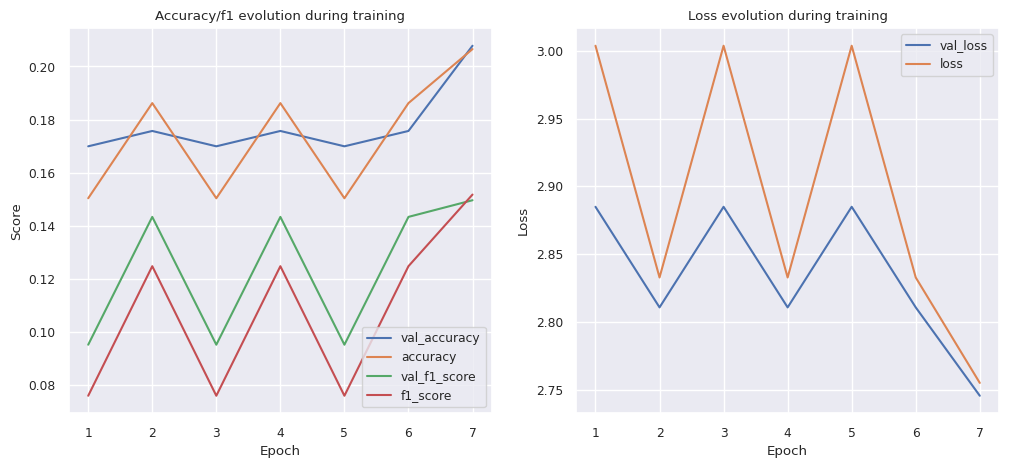

In [145]:
history = get_full_training_history(111,training_history)
if history != None:
  save_training_history(111,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

In [146]:

print(classification_report(y_test.astype("str"),test_pred_class))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          10       0.31      0.07      0.11       311
        1140       0.25      0.00      0.01       267
        1160       0.55      0.22      0.31       396
        1180       0.00      0.00      0.00        76
        1280       0.11      0.12      0.12       487
        1281       0.07      0.02      0.03       207
        1300       0.20      0.25      0.22       505
        1301       0.00      0.00      0.00        81
        1302       0.05      0.01      0.01       249
        1320       0.00      0.00      0.00       324
        1560       0.00      0.00      0.00       507
        1920       0.50      0.27      0.35       431
        1940       0.00      0.00      0.00        81
        2060       0.25      0.23      0.24       499
        2220       0.00      0.00      0.00        82
        2280       0.20      0.74      0.31       476
        2403       0.29      0.33      0.31       477
        2462       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [147]:


def plot_confusion_matrix(cm):
  plt.figure(figsize=(15, 8))
  sns.set(font_scale=0.8)
  sns.heatmap(cm, annot=True, cbar=True, square=False,fmt='g'
              ,xticklabels=classes_keras,yticklabels=classes_keras)
  plt.xlabel('Prédit')
  plt.ylabel('Réel')
  plt.title('Matrice de confusion')
  plt.show()

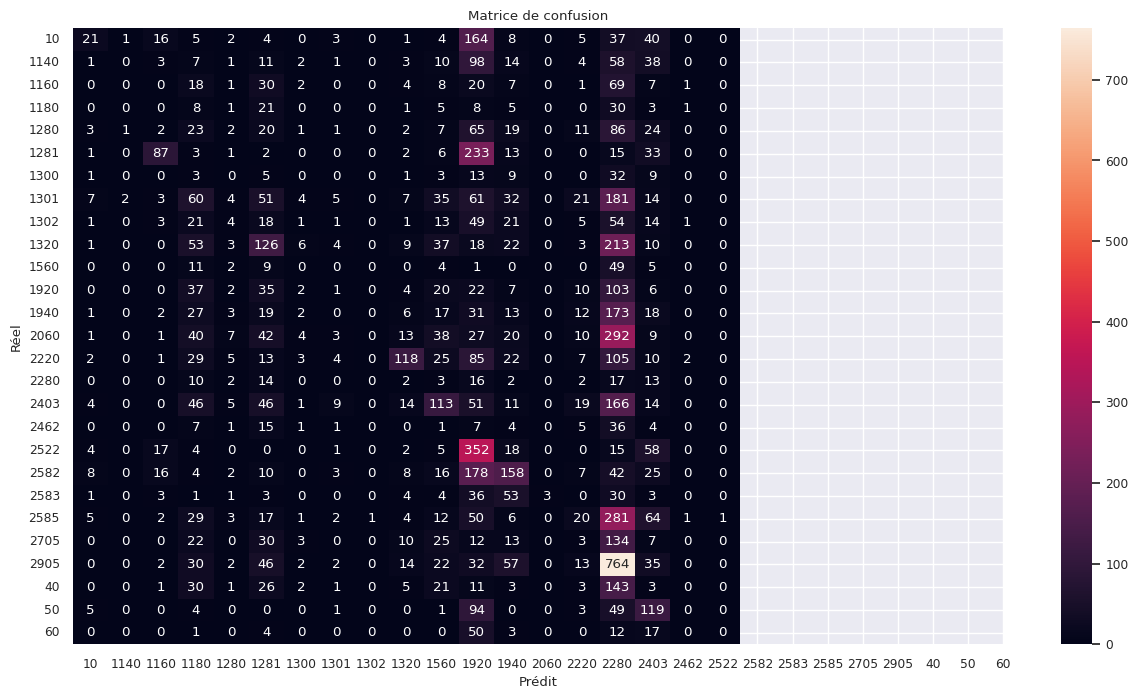

In [148]:
cm = pd.crosstab(y_test,test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))

